In [116]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import z,y,t
import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo


## First will Model a non-linear Pendulem

For generalisation will derive EoM with lagrange method

In [117]:
me.dynamicsymbols('q:3')

In [118]:
m,g,l_0,k = sym.symbols(['m','g','l_0','k'])
qs = 2
q = sym.Matrix(me.dynamicsymbols(f'q:{qs}'))
qd = sym.Matrix(me.dynamicsymbols(f'q:{qs}',1))
qdd = sym.Matrix(me.dynamicsymbols(f'q:{qs}',2))

### Potential Energy

In [127]:
half = sym.Rational(1,2)
U = m*g*(q[1]-l_0*sym.cos(q[0])) + sym.Rational(1,2)*k*(q[1])**2
U

### Kinetic Energy

to be overly general will derive using a transformtion matrix to get from the base frame to the frame of the CoM, then will use the jacobian and a mass matrix to get the K.E of the Pendulom.

More Explictly

the kinetic enrgy of a partical is:

$K.E. = \frac{1}{2}\dot{\vec{x}}^TM(q)\dot{\vec{x}}$

Where, 

$\vec{v} = \left[ \begin{array}{} v_x & v_y & v_z & \omega_x & \omega_y & \omega_z  \end{array}  \right]^T $

$ M = \left[\begin{matrix}m & 0 & 0 & 0 & 0 & 0\\0 & m & 0 & 0 & 0 & 0\\0 & 0 & m & 0 & 0 & 0\\0 & 0 & 0 & I_{xx} & I_{xy} & I_{xz}\\0 & 0 & 0 & I_{xy} & I_{yy} & I_{yz}\\0 & 0 & 0 & I_{xz} & I_{yz} & I_{zz}\end{matrix}\right] $

To convert this into joint space (e.g. generalised coordinates) can use the Jacobian

$\dot{\vec{x}} = \mathbf{J}\dot{\vec{q}} $

$ K.E =\frac{1}{2}\dot{\vec{q}}^T \mathbf{J}^T M(q)  \mathbf{J}  \dot{\vec{q}} $

J is defined as $\mathbf{J} = \frac{\partial x}{\partial q}$

hence if we find the transform $\vec{x} = \mathbf{A}\vec{q}$, we can find J, by taking the partial derivates of the RHS with respect to each of the generilsed coordinates



In [128]:
me.mechanics_printing()
# get the transform matrix
Transform = symt.HomogenousTransform().Translate(0,0,q[1]).R_x(-sym.pi*sym.Rational(1,2)+q[0]).Translate(0,l_0,0)
# get the jacobian of x,y,z positon
J_xyz = Transform.Transform_point([0,0,0]).jacobian(q)
# get jacobian of rotations
J_r = sym.Matrix([q[0],0,0]).jacobian(q)

J=sym.zeros(6,len(q))
J[:3,:] = J_xyz
J[3:,:] = J_r
J

⎡    0       0⎤
⎢             ⎥
⎢l₀⋅cos(q₀)  0⎥
⎢             ⎥
⎢l₀⋅sin(q₀)  1⎥
⎢             ⎥
⎢    1       0⎥
⎢             ⎥
⎢    0       0⎥
⎢             ⎥
⎣    0       0⎦

In [129]:
# create mass matrix of CoM in its frame
M_q = sym.diag(m,m,m,0,0,0)

#calculate the mass Matrix
M = J.T*M_q*J
M.simplify()
M
#calculate the K.E
T = (sym.Rational(1,2)*qd.T*M*qd)[0]
T


In [130]:
Lag = sym.Matrix([T-U])

Lag

⎡                              2   ⎛  2                       ⎞               
⎢                          k⋅q₁    ⎜l₀ ⋅m⋅q₀̇   l₀⋅m⋅sin(q₀)⋅q₁̇⎟      ⎛l₀⋅m⋅s
⎢-g⋅m⋅(-l₀⋅cos(q₀) + q₁) - ───── + ⎜──────── + ───────────────⎟⋅q₀̇ + ⎜───────
⎣                            2     ⎝   2              2       ⎠      ⎝       2

                  ⎤
in(q₀)⋅q₀̇   m⋅q₁̇⎞   ⎥
──────── + ────⎟⋅q₁̇⎥
           2  ⎠   ⎦

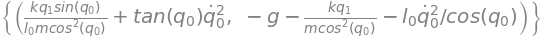

In [154]:
Lag = sym.Matrix([T-U])
term_1 = Lag.jacobian(qd).diff(me.dynamicsymbols._t).T
term_2 = Lag.jacobian(q).T
EoM = term_1-term_2
EoM
sym.linsolve(list(EoM[:]),list(qdd))

In [140]:
sym.simplify(sym.simplify(EoM.jacobian(qdd)**-1)*sym.simplify((EoM-EoM.jacobian(qdd)*qdd))*-1).diff(q[0],q[0]).subs(q[0],sym.pi/2)
#sym.simplify(EoM.subs({q[1]:0}))

⎡                2⋅zoo⋅k⋅q₁                      ⎤
⎢                ────────── + zoo                ⎥
⎢                   l₀⋅m                         ⎥
⎢                                                ⎥
⎢    ⎛                       2                 2⎞⎥
⎢    ⎜2⋅zoo⋅k⋅q₁      ⎛d ⎛π⎞⎞           ⎛d ⎛π⎞⎞ ⎟⎥
⎢zoo⋅⎜────────── + l₀⋅⎜──⎜─⎟⎟  + zoo⋅l₀⋅⎜──⎜─⎟⎟ ⎟⎥
⎣    ⎝    m           ⎝dt⎝2⎠⎠           ⎝dt⎝2⎠⎠ ⎠⎦

In [138]:
(qd[0]*q[0]).diff(q[0])

In [150]:
# calculate LHS of Lagranagian Equation
Lag = sym.Matrix([T-U])
term_1 = Lag.jacobian(qd).diff(me.dynamicsymbols._t).T
term_2 = Lag.jacobian(q).T
EoM = term_1-term_2
sym.simplify(EoM)
a_eq = sym.linsolve(list(EoM[:]),list(qdd))
sym.simplify(a_eq.args[0][0]*(l_0**2*m**2*sym.cos(q[0])**2)).expand()

In [126]:
# solve for each acceleration term
a_eq = sym.linsolve(list(EoM[:]),list(qdd))

# create funcs
funcs = []
for i in range(0,len(q)):
    funcs.append(sym.lambdify((m,g,l_0,k,q,qd),a_eq.args[0][i]))

# create single sys func
def deriv(t,y,m,g,l_0,k):
    result = ()
    qs=[]
    qds=[]
    for i in range(0,len(q)):
        qs.append(y[i*2])
        qds.append(y[i*2+1])
        
    for i in range(0,len(q)):
        result = (result + (y[i*2+1],))
        
        v = funcs[i](m,g,l_0,k,qs,qds)  
        
        result = (result + (v,))
    
    #ThetaDot = z1
    #z1dot = thetadd_func(m,g,l_0,[Theta],[z1])
    return result
deriv(0,[0.5,0,1,0],1,10,1,1)

In [95]:
## patch the singularity
def deriv_sing(t,y,m,g,l_0,k,sigma=0.00000001):
    #val = np.abs(y[0]) / np.pi/2
    error = np.sin(y[0])
    if error>0.99:
        thetadot = (-k*y[2])/(2*l_0*m)
        dDot = -g
        r = y[1],thetadot,y[3],dDot
        return r
    elif error<-0.99
    
    if (error <=sigma) & (error >=-sigma):
        thetadot = (-k*y[2])/(2*l_0*m)
        #thetadot = (g*l_0+k*y[2]/(m*l_0)+g/l_0)/2
        dDot = -g
        r = y[1],thetadot,y[3],dDot
        return r
    
    else:
        return deriv(t,y,m,g,l_0,k)

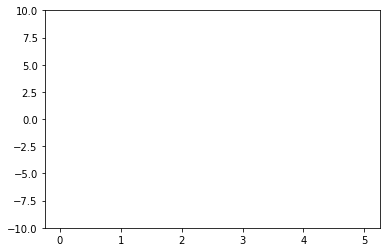

In [112]:
params = (1,10,1,100) # m,g,l_0,k
# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 5, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt
y0 = [0.1,0,1,0]
yData = solve_ivp(lambda t,y:deriv_sing(t,y,*params,0.01),(0,tmax),y0,max_step=dt)

yData.y[0][0]
fig = plt.figure()
#ax = plt.plot(yData.t,yData.y[2])


#calculate the total energy in the system
def KineticEnergy(m,g,l_0,k,y):
    xdot = l_0*y[1]*np.cos(y[0])
    ydot = y[3]*l_0*y[1]*np.sin(y[0])
    return 0.5*m*(xdot**2+ydot**2)

def PotentialEnergy(m,g,l_0,k,y):
    y = y[2]+l_0*(1-np.cos(y[0]))
    return 0.5*k*y[2]**2+m*g*y

def Energy(m,g,l_0,k,y):
    return KineticEnergy(m,g,l_0,k,y) + PotentialEnergy(m,g,l_0,k,y)

ax = plt.plot(yData.t,Energy(*params,yData.y))
plt.gca().set_ylim(-10,10)


In [113]:
yData.y.T[0]

array([0.1, 0. , 1. , 0. ])

In [114]:
# interpolate data onto a uniform time grid
t = np.arange(0, tmax+dt, 0.01)
thetas = np.interp(t,yData.t,yData.y[0])
ds = np.interp(t,yData.t,yData.y[2])

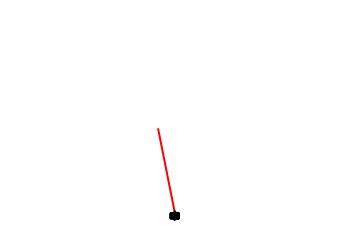

In [115]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

def plot_FWT(theta, d, L,fwt):
    xs = [0,L*np.sin(theta)]
    ys = [d,(d)-(L*np.cos(theta))]
    fwt.set_data(xs,ys)
    
def plot_sys(theta, d, L, ax, r=0.1):
    plot_spring(np.pi,1)
    plot_FWT(np.pi/2,0,1)
    c0 = Circle((0, d+1), r/2, fc='k', zorder=10)
    ax.add_patch(c0)
    ax.set()

    
fig = plt.figure()
ax = plt.axes(xlim=(-1.5,1.5),ylim=(-1,3.5))
ax.axis('equal')
ax.set()
fwt, = ax.plot([], [], 'r-',lw=2)
spring = cpo.Spring.FromLengthAndAngle(np.pi/2,1,ax = ax)



#spring, = ax.plot([], [], 'k-',lw=2) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    fwt.set_data([], [])
    spring.ReplotSpring((0,0),np.pi,1)              
    return fwt,spring.springObj
                    
def animate(i):
    theta = thetas[i]
    d = ds[i]
    plot_FWT(theta,d+1,1,fwt)
    spring.ReplotSpring((0,0),np.pi,d+1)   
    return fwt,spring.springObj
                    
plt.axis('off')    
#plt.rcParams['animation.ffmpeg_path'] = r'.'                    
# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=25, blit=True)
# equivalent to rcParams['animation.html'] = 'html5'
#anim
# anim.save(r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop\mymovie.mp4',writer=mywriter)
#plt.show()
#mywriter = animation.FFMpegWriter()
#animation.writers['ffmpeg'] = mywriter
#writer = animation.ImageMagickFileWriter()
HTML(anim.to_html5_video())

In [46]:
n,d = sym.fraction(a_eq.args[0][0])
print(n.diff(q[0]).subs(q[0],sym.pi/2).simplify())

#n = n.diff(q[0],q[0])#.subs(q[0],sym.pi/2).simplify()
#d = d.diff(q[0],q[0])#.subs(q[0],sym.pi/2).simplify()
v, = sym.symbols(['v'])
g, = sym.symbols(['g:2'])
sym.printing.octave_code((n/d).subs({qd[0]:v,q[0]:g[0],q[1]:g[1]}))

nan


'g1.*k.*sin(g0)./(l_0.*m.*cos(g0).^2) + v.^2.*tan(g0)'

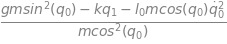

In [463]:
np.arctan2()

In [341]:
n,d = sym.fraction(a_eq.args[0][1])
print(n.diff(q[0]).subs(q[0],sym.pi/2).simplify())

n = n.diff(q[1])#.subs(q[0],sym.pi/2).simplify()
d = d.diff(q[1])#.subs(q[0],sym.pi/2).simplify()

n/d

0


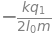

In [134]:
((sym.simplify(a_eq.args[0][0]*sym.cos(q[0])**2).diff(q[0],q[0]))/(((sym.cos(q[0])**2).diff(q[0],q[0])))).subs(q[0],sym.pi*half)

In [166]:
f'{(1,2)}'

'(1, 2)'

In [167]:
a

In [182]:
deriv_sing(0,[np.pi/2+0.1,0,0,0],3,10,1,100)